 # Replication and correction
 In this notebook, the results presented in "Betting on a buzz" by RRS are replicated, and corrected where necessary.

In [1]:
import pandas as pd
import seaborn as sns
from linearmodels import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from fixedeffect.fe import fixedeffect
import matplotlib.ticker as mtick
from collections import defaultdict
import matplotlib.dates as mdates
import warnings
import requests
plt.style.use('default')

warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)
# ANSI escape code for bold text
BOLD = '\033[1m'
END = '\033[0m'

In [2]:
# Read the data
original_df = pd.read_csv("../data/ramirez_matches_cleaned.csv", index_col=0)

original_df.reset_index(inplace=True,drop=True)
original_df['error'] = 0
original_df['tournament'] = original_df['tournament'].astype('category').cat.codes

# Create a new column that combines 'tournament' and 'year' into a single string
original_df['tournament_and_year'] = original_df['year'].astype(str) + '_' + original_df['tournament'].astype(str)
# Convert the new 'tournament_and_year' column to categorical and get its codes
original_df['tournament_and_year'] = original_df['tournament_and_year'].astype('category').cat.codes

original_df['overround_b365'] = original_df.groupby('match_id')['inverse_b365'].transform(lambda x: x.sum(min_count=1) - 1)
original_df['overround_avg'] = original_df.groupby('match_id')['inverse_avg'].transform(lambda x: x.sum(min_count=1) - 1)
original_df['overround_best'] = original_df.groupby('match_id')['inverse_best'].transform(lambda x: x.sum(min_count=1) - 1)

# Set the 'error' column values based on the conditions
original_df.loc[original_df['outcome'] == 1, 'error'] = 1 - original_df['inverse_avg']
original_df.loc[original_df['outcome'] != 1, 'error'] = 0 - original_df['inverse_avg']


fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset.reset_index(inplace=True)
print('Fit set rows: '+str(len(fitset)))
print('Test set rows: '+str(len(testset)))

Fit set rows: 15854
Test set rows: 5190


### Highlighting the erroneous row
Note how inverse_b365 < inverse_best when it should be greater than or equal to.
This is removed from the data frames we use.

In [3]:
testset[(testset['match_id'] == 5883) & (testset['player'] == 'Polona Hercog')]

,index,match_id,tournament,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best
1135,16989,5883,69,Polona Hercog,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,0.47619,1,0.459459,247,0.059011,0.03559,-0.101869


In [4]:
# Remove Hercog bet from both of the data frames we will use!
testset_no_hercog = testset.drop(testset[(testset['match_id'] == 5883) & (testset['player'] == 'Polona Hercog')].index)
original_df.drop(original_df[(original_df['match_id'] == 5883) & (original_df['player'] == 'Polona Hercog')].index, inplace=True)

### Declare functions for result output

In [5]:
# Select regression by setting rankdist and wikibuzz True or False.
# For models PM, PM w/o RD (aka. WB), RD, MO.
def fit_regression(train_set, rankdist: bool = True, wikibuzz: bool = True):
    if wikibuzz and rankdist:
        formula = 'outcome ~ inverse_avg + rankdist + wikibuzz' # params = [constant, inverse_avg, rankdist, wikibuzz]
    elif wikibuzz and not rankdist:
        formula = 'outcome ~ inverse_avg + wikibuzz' # params = [constant, inverse_avg, wikibuzz]
    elif rankdist and not wikibuzz:
        formula = 'outcome ~ inverse_avg + rankdist' # params = [constant, inverse_avg, rankdist]
    else:
        formula = 'outcome ~ inverse_avg' # params = [constant, inverse_avg]
    results = smf.ols(formula, data=train_set).fit(cov_type='cluster', cov_kwds={'groups': fitset['match_id']})
    params = results.params
    return params


def simple_probability(params: pd.Series,
                         inverse_odds: float):
    y_hat = params[0] + params[1]*inverse_odds
    return y_hat

# Returns model's estimated probability.
def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    y_hat = params[0] + params[1]*inverse_odds
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat += params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat += params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat += params[-1] * wikibuzz
    return y_hat

# Determine Kelly stake
def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    return max(y_hat - ((1 - y_hat)/(odds - 1)), 0)

# Calculate Profit/Loss
def profit_loss(kelly, odds_implied_prob, outcome):
    return kelly * (outcome / odds_implied_prob - 1)

# Estimates probability according to model selection, creates new columns, and prints results
def show_results(testset, params, odds, estimated_probabilities, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    # Estimate Probability
    testset[estimated_probabilities] = testset.apply(lambda row: estimate_probability(params,
                                                                                 inverse_odds=row['inverse_avg'],
                                                                                 rankdist=row['rankdist'] if rankdist else None,
                                                                                 wikibuzz=row['wikibuzz'] if wikibuzz else None),axis=1)
    # Determine kelly bet size
    testset.loc[:, 'kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)], testset[estimated_probabilities])]
    # Calculate return for the bet.
    testset.loc[:, 'PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)], testset['outcome'])]

    # Print Statistics
    inverse_odds_col = f'inverse_{odds}'
    overround_col = f'overround_{odds}'

    bets_considered = len(testset[testset[inverse_odds_col].notna()])
    bets_placed = len(testset.loc[(testset["PnL"].notna()) & (testset["PnL"] != 0)])
    mean_overround = testset[testset[overround_col] != 0][overround_col].mean() * 100
    absolute_bet_amount = testset['kelly_betsize'].sum()
    absolute_return = testset['PnL'].sum()
    roi = (((absolute_return + absolute_bet_amount) / absolute_bet_amount) - 1) * 100

    print(f'''
    Bets considered (2 * Matches): {bets_considered}
    Number of bets placed: {bets_placed}
    Mean overround (%): {mean_overround:.3f}
    Absolute amount bet: {absolute_bet_amount:.2f}
    Absolute return: {absolute_return:.2f}
    ROI (%): {roi:.2f}
    ''')
    return testset

# PnL plot
def plot_results(primary_data, compare_data=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Convert 'date' columns to datetime objects
    primary_data['date'] = pd.to_datetime(primary_data['date'])
    primary_data['Cum_PnL'] = primary_data['PnL'].cumsum() * 100
    max_value = primary_data['Cum_PnL'].max()
    if compare_data is not None:
        compare_data['date'] = pd.to_datetime(compare_data['date'])
        compare_data['Cum_PnL'] = compare_data['PnL'].cumsum() * 100
        compare_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='Without Hercog bet')
        primary_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='With Hercog bet', linestyle='--', color='black')
        max_value = max(max_value, compare_data['Cum_PnL'].max())
    else:
        primary_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='Cumulative PnL', linestyle='--', color='black')
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.legend(fancybox=False, shadow=False, frameon=True, facecolor='white', framealpha=1)

    # Quarterly x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    
    def custom_formatter(x, pos):
        month = mdates.num2date(x).month
        quarter = (month-1)//3 + 1
        year = mdates.num2date(x).year
        return f"Q{quarter} {year}"

    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    fig.autofmt_xdate()

    plt.rcParams.update({'font.size': 14})
    if max_value > 200:
        ax.set_ylim(-50, 400)
    else:
        ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey', linewidth=2.5)
    
    ax.set_facecolor('white')  # Set the background color of the plot to white
    fig.patch.set_facecolor('white') 
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    plt.show()

# Estimates probability according to model selection, creates new columns, and prints results - WITH CUMULATIVE KELLY
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    
    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    #print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print("Mean overround (%): "+str(testset[testset['overround_{}'.format(odds)] != 0]['overround_{}'.format(odds)].mean()*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))
    
# PnL plot - WITH CUMULATIVE KELLY
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    plt.show()

## Results

In [6]:
# What the data frame looks like
fitset.head(3)

,match_id,tournament,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,inverse_best,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best
0,12776,83,Evgeniya Rodina,2015-07-02,2015.0,0.023432,0.0,0.250000,0.246914,0.222222,0,-0.246914,26,0.069672,0.059922,0.015873
1,12785,83,Ajla Tomljanovic,2015-07-02,2015.0,0.064577,0.0,0.166667,0.181818,0.164474,0,-0.181818,26,0.059524,0.059011,0.019175
2,12784,83,Svetlana Kuznetsova,2015-07-02,2015.0,-0.032537,0.0,0.819672,0.813008,0.800000,0,-0.813008,26,0.069672,0.055139,0.015054


### Table 1 Fixed results

In [7]:
# PM
mod = IV2SLS.from_formula('error ~ inverse_avg + rankdist + wikibuzz + C(year)', fitset)
resid = mod.fit(cov_type='clustered', clusters=fitset[['tournament_and_year', 'match_id']])
print(f"{BOLD}Preferred Model summary:{END}\n", resid)
# PM w/o RD
mod = IV2SLS.from_formula('error ~ inverse_avg + wikibuzz + C(year)', fitset)
resid = mod.fit(cov_type='clustered', clusters=fitset[['tournament_and_year', 'match_id']])
print(f"{BOLD}\nPreferred Model without RankDist variable summary:{END}\n", resid)

Preferred Model summary:
                             OLS Estimation Summary                            
Dep. Variable:                  error   R-squared:                      0.0011
Estimator:                        OLS   Adj. R-squared:                 0.0007
No. Observations:               15854   F-statistic:                    229.44
Date:                Thu, Jul 11 2024   P-value (F-stat)                0.0000
Time:                        13:40:14   Distribution:                  chi2(6)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -0.0433     0.0151    -2.8585     0.0043     -0.0730     -0.013

### Table 2 Average Odds 


    Bets considered (2 * Matches): 5190
    Number of bets placed: 221
    Mean overround (%): 5.327
    Absolute amount bet: 4.30
    Absolute return: -0.27
    ROI (%): -6.37
    


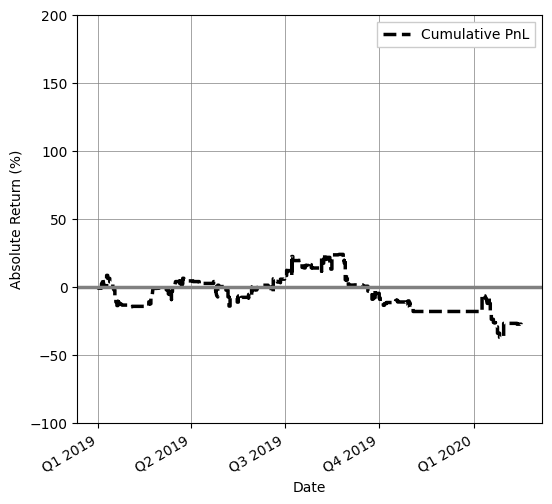

In [8]:
params = fit_regression(train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="avg")
plot_results(testset)

### Table 2 PM results and Figure 1a plot


    Bets considered (2 * Matches): 5156
    Number of bets placed: 312
    Mean overround (%): 6.456
    Absolute amount bet: 7.15
    Absolute return: 1.24
    ROI (%): 17.29
    

    Bets considered (2 * Matches): 5155
    Number of bets placed: 311
    Mean overround (%): 6.457
    Absolute amount bet: 6.77
    Absolute return: -0.50
    ROI (%): -7.36
    


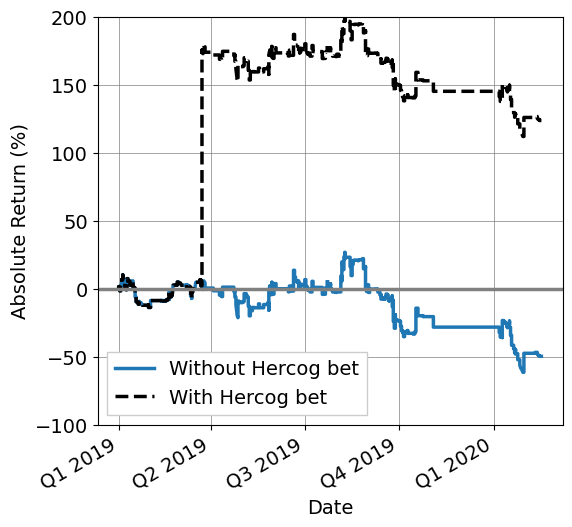

In [9]:
params = fit_regression(rankdist=True, train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=True)
show_results(testset_no_hercog, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=True)
plot_results(testset, testset_no_hercog)

### Table 1/2 PM w/o RD results and Figure 1b plot


    Bets considered (2 * Matches): 5156
    Number of bets placed: 276
    Mean overround (%): 6.456
    Absolute amount bet: 4.99
    Absolute return: 1.44
    ROI (%): 28.82
    

    Bets considered (2 * Matches): 5155
    Number of bets placed: 275
    Mean overround (%): 6.457
    Absolute amount bet: 4.60
    Absolute return: -0.29
    ROI (%): -6.31
    


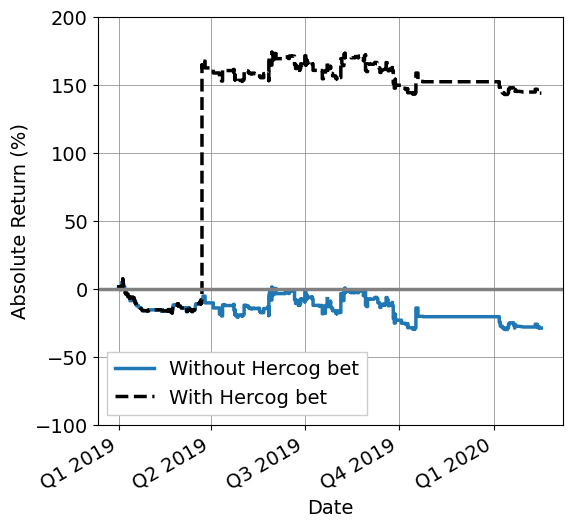

In [10]:
params = fit_regression(rankdist=False, train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=False)
show_results(testset_no_hercog, estimated_probabilities='model_est_prob', params=params, odds="b365", rankdist=False)
plot_results(testset, testset_no_hercog)

### Table 2 PM Best Odds results and Figure 2a plot


    Bets considered (2 * Matches): 5189
    Number of bets placed: 2350
    Mean overround (%): -0.244
    Absolute amount bet: 76.63
    Absolute return: 2.34
    ROI (%): 3.05
    


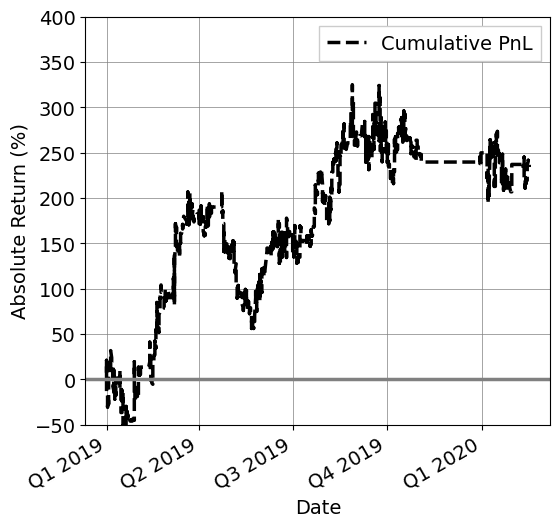

In [11]:
params = fit_regression(rankdist=True, train_set=fitset)
show_results(testset, estimated_probabilities='model_est_prob', params=params, odds="best")
plot_results(testset)

### Using N=5188 Odds - Table 1 Disputed
Discussed in Appendix B of the arXiv paper, a slight difference in calclulation by RRS means that they provide some mismatched values.

These relate to the handling of two rows, where for the calclulation of values given in Table B.6, RRS includes them in the data for some but not others.

Here we show the results when they are excluded (providing the bets considered and mean overround values given by RRS).

In [12]:
print("Matches of note:")
testset[((testset['player'] == 'Anastasia Potapova') & (testset['date'] == '2019-07-15')) | ((testset['player'] == 'Kristina Kucova') & (testset['date'] == '2019-07-15'))]

Matches of note:


,index,match_id,tournament,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,...,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best,model_est_prob,kelly_betsize,PnL,Cum_PnL
2871,18725,13918,49,Kristina Kucova,2019-07-15,2019.0,0.007736,0.395896,0.400000,0.398406,...,0,-0.398406,233,0.066667,0.052001,-0.386503,0.370926,NaN,NaN,NaN
2874,18728,13918,49,Anastasia Potapova,2019-07-15,2019.0,-0.007736,-0.395896,0.666667,0.653595,...,1,0.346405,233,0.066667,0.052001,-0.386503,0.624522,0.028524,0.01797,151.368516


In [13]:
filtered_testset = testset[~((testset['player'] == 'Anastasia Potapova') & (testset['date'] == '2019-07-15')) & ~((testset['player'] == 'Kristina Kucova') & (testset['date'] == '2019-07-15'))].copy()
# Table 2 PM Best Odds results and Figure 2a plot
params = fit_regression(rankdist=True, train_set=fitset)
show_results(filtered_testset, estimated_probabilities='model_est_prob', params=params, odds="best")


    Bets considered (2 * Matches): 5188
    Number of bets placed: 2349
    Mean overround (%): -0.230
    Absolute amount bet: 76.60
    Absolute return: 2.32
    ROI (%): 3.03
    


,index,match_id,tournament,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,...,outcome,error,tournament_and_year,overround_b365,overround_avg,overround_best,model_est_prob,kelly_betsize,PnL,Cum_PnL
0,15854,1981,16,Petra Kvitova,2019-01-01,2019.0,-0.115079,-0.214383,0.833333,0.806452,...,1,0.193548,207,0.064280,0.052757,0.003472,0.776990,0.000000,0.000000,0.000000
1,15855,1980,67,Veronika Kudermetova,2019-01-01,2019.0,0.016291,1.875280,0.266667,0.257069,...,1,0.742931,246,0.066667,0.050720,-0.021363,0.239881,0.016972,0.057875,5.787509
2,15856,1979,16,Johanna Konta,2019-01-01,2019.0,0.139640,0.195659,0.500000,0.476190,...,1,0.523810,207,0.081395,0.050903,0.010101,0.456068,0.002792,0.003351,6.122573
3,15857,1988,16,Anastasija Sevastova,2019-01-01,2019.0,-0.062338,-0.923888,0.714286,0.694444,...,1,0.305556,207,0.077922,0.055455,-0.036597,0.658637,0.000000,0.000000,6.122573
4,15858,1977,2,Su-Wei Hsieh,2019-01-01,2019.0,-0.023950,0.310155,0.666667,0.645161,...,1,0.354839,211,0.066667,0.051665,-0.006275,0.621373,0.020378,0.012838,7.406407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,21039,4139,50,Ekaterina Alexandrova,2020-02-15,2020.0,0.089286,1.323982,0.500000,0.483092,...,0,-0.483092,267,0.055556,0.054520,-0.019139,0.470591,0.029417,-0.029417,238.576282
5186,21040,4139,50,Kiki Bertens,2020-02-15,2020.0,-0.089286,-1.323982,0.555556,0.571429,...,1,0.428571,267,0.055556,0.054520,-0.019139,0.527439,0.002370,0.002133,238.789606
5187,21041,4142,50,Maria Sakkari,2020-02-15,2020.0,-0.007619,-1.612937,0.421941,0.431034,...,0,-0.431034,267,0.058884,0.056034,-0.000121,0.385370,0.000000,-0.000000,238.789606
5188,21042,4143,50,Kiki Bertens,2020-02-16,2020.0,-0.085000,-2.935837,0.636943,0.641026,...,1,0.358974,267,0.058884,0.055963,0.007218,0.584445,0.000000,0.000000,238.789606


### Table 5 Results Corrected.

In [14]:
def table_5_results(data, strict_inequality, range_1, range_2=None):
    if strict_inequality == 'yes':
        if (range_2 is None) and (isinstance(range_1, tuple)) and (len(range_1) == 2):
            lower_bound, upper_bound = range_1
            fitset = data[((data['inverse_avg'] > lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] < 2019)].copy()
            testset = data[((data['inverse_avg'] > lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] >= 2019)].copy()

        elif range_2 and (isinstance(range_1, tuple)) and (len(range_1) == 2) and (isinstance(range_2, tuple)) and (len(range_2) == 2):
            lower_bound_r1, upper_bound_r1 = range_1
            lower_bound_r2, upper_bound_r2 = range_2
            fitset = data[(((data['inverse_avg'] > lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] > lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] < 2019)].copy()
            testset = data[(((data['inverse_avg'] > lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] > lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] >= 2019)].copy()
        else:
            print("Param issue")
            return None

    elif strict_inequality == 'no':
        if (range_2 is None) and (isinstance(range_1, tuple)) and (len(range_1) == 2):
            lower_bound, upper_bound = range_1
            fitset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] <= upper_bound)) & (data['year'] < 2019)].copy()
            testset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] <= upper_bound)) & (data['year'] >= 2019)].copy()

        elif range_2 and (isinstance(range_1, tuple)) and (len(range_1) == 2) and (isinstance(range_2, tuple)) and (len(range_2) == 2):
            lower_bound_r1, upper_bound_r1 = range_1
            lower_bound_r2, upper_bound_r2 = range_2
            fitset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] <= upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] <= upper_bound_r2))) & (data['year'] < 2019)].copy()
            testset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] <= upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] <= upper_bound_r2))) & (data['year'] >= 2019)].copy()
        else:
            print("Param issue")
            return None
    elif strict_inequality == 'rrs_half_strict':
        if (range_2 is None) and (isinstance(range_1, tuple)) and (len(range_1) == 2):
            lower_bound, upper_bound = range_1
            fitset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] < 2019)].copy()
            testset = data[((data['inverse_avg'] >= lower_bound) & (data['inverse_avg'] < upper_bound)) & (data['year'] >= 2019)].copy()

        elif range_2 and (isinstance(range_1, tuple)) and (len(range_1) == 2) and (isinstance(range_2, tuple)) and (len(range_2) == 2):
            lower_bound_r1, upper_bound_r1 = range_1
            lower_bound_r2, upper_bound_r2 = range_2
            fitset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] < 2019)].copy()
            testset = data[(((data['inverse_avg'] >= lower_bound_r1) & (data['inverse_avg'] < upper_bound_r1)) | ((data['inverse_avg'] >= lower_bound_r2) & (data['inverse_avg'] < upper_bound_r2))) & (data['year'] >= 2019)].copy()
        else:
            print("Param issue")
            return None

    testset.dropna(subset=['inverse_b365'], inplace=True)
    formula = 'outcome ~ inverse_avg + wikibuzz'
    results = smf.ols(formula, data=fitset).fit(cov_type='cluster', cov_kwds={'groups': fitset['match_id']})
    params = results.params
    return show_results(testset, params=params, estimated_probabilities='model_est_prob', odds="b365", rankdist=False)

### RRS Table 5

In [15]:
# RRS INCORRECT Table 5 Results Column I: p∈(0,0.2)∪[0.8,1)
print(f"Incorrect with p∈(0,0.2)∪{BOLD}[{END}0.8,1):\n")
table_5_results(strict_inequality='rrs_half_strict', data=original_df, range_1=(0,0.2), range_2=(0.8,1))
# RRS CORRECT Table 5 Results Column I: p∈(0,0.2)∪(0.8,1)
print(f"\nCorrect with p∈(0,0.2)∪{BOLD}({END}0.8,1):\n")
table_5_results(strict_inequality='yes', data=original_df, range_1=(0,0.2), range_2=(0.8,1));

Incorrect with p∈(0,0.2)∪[0.8,1):


    Bets considered (2 * Matches): 732
    Number of bets placed: 4
    Mean overround (%): 5.710
    Absolute amount bet: 0.05
    Absolute return: -0.00
    ROI (%): -3.02
    

Correct with p∈(0,0.2)∪(0.8,1):


    Bets considered (2 * Matches): 702
    Number of bets placed: 7
    Mean overround (%): 5.701
    Absolute amount bet: 0.18
    Absolute return: -0.06
    ROI (%): -33.80
    


In [16]:
# RRS CORRECT Table 5 Results Column II: p∈(0,0.4)∪(0.6,1)
print(f"\nCorrect with p∈(0,0.4)∪(0.6,1):\n")
table_5_results(strict_inequality='yes', data=original_df, range_1=(0,0.4), range_2=(0.6,1));


Correct with p∈(0,0.4)∪(0.6,1):


    Bets considered (2 * Matches): 3459
    Number of bets placed: 87
    Mean overround (%): 6.184
    Absolute amount bet: 1.03
    Absolute return: 0.01
    ROI (%): 0.81
    


In [17]:
# RRS INCORRECT Table 5 Results Column III: p∈[0.2,0.8)
print(f"Incorrect (Hercog removed but wrong interval) with p∈[0.2,0.8{BOLD}){END} :\n")
table_5_results(strict_inequality='rrs_half_strict', data=original_df, range_1=(0.2,0.8))
print(f"\nCorrect (Hercog removed, correct interval) with p∈[0.2,0.8{BOLD}]{END}:\n")
table_5_results(strict_inequality='no', data=original_df, range_1=(0.2,0.8));

Incorrect (Hercog removed but wrong interval) with p∈[0.2,0.8) :


    Bets considered (2 * Matches): 4423
    Number of bets placed: 362
    Mean overround (%): 6.580
    Absolute amount bet: 6.87
    Absolute return: -0.24
    ROI (%): -3.52
    

Correct (Hercog removed, correct interval) with p∈[0.2,0.8]:


    Bets considered (2 * Matches): 4453
    Number of bets placed: 383
    Mean overround (%): 6.576
    Absolute amount bet: 7.57
    Absolute return: -0.25
    ROI (%): -3.36
    


In [18]:
# RRS CORRECT Table 5 Results Column IV: p∈[0.4,0.6]
print(f"\nCorrect (Hercog removed) with p∈[0.4,0.6]:\n")
table_5_results(strict_inequality='no', data=original_df, range_1=(0.4,0.6));


Correct (Hercog removed) with p∈[0.4,0.6]:


    Bets considered (2 * Matches): 1696
    Number of bets placed: 262
    Mean overround (%): 7.013
    Absolute amount bet: 8.91
    Absolute return: 1.11
    ROI (%): 12.44
    
